# Assignment 5 - Reinforcement Learning

## *Joseph Littell*
Netid:  *JPL51*

### Blackjack

Your goal is to develop a reinforcement learning technique to learn the optimal policy for winning at blackjack. Here, we're going to modify the rules from traditional blackjack a bit in a way that corresponds to the game presented in Sutton and Barto's *Reinforcement Learning: An Introduction* (Chapter 5, example 5.1). A full implementation of the game is provided and usage examples are detailed in the class header below.

The rules of this modified version of the game of blackjack are as follows:

- Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  We're playing against a fixed (autonomous) dealer.
- Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and we're refer to it as 'usable' at 11 (indicating that it could be used as a '1' if need be. This game is placed with a deck of cards sampled with replacement.
- The game starts with each (player and dealer) having one face up and one face down card.
- The player can request additional cards (hit, or action '1') until they decide to stop (stay, action '0') or exceed 21 (bust, the game ends and player loses).
- After the player stays, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.



You will accomplish three things:
1. Try your hand at this game of blackjack and see what your human reinforcement learning system is able to achieve
2. Evaluate a simple policy using Monte Carlo policy evaluation
3. Determine an optimal policy using Monte Carlo control

*This problem is adapted from David Silver's [excellent series on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) at University College London*

## 1

### [10 points] Human reinforcement learning 

Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. This will help you get accustomed with how the game works, the data structures involved with representing states, and what strategies are most effective.

In [2]:
import numpy as np

class Blackjack():
    """Simple blackjack environment adapted from OpenAI Gym:
        https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with a deck sampled with replacement.
    
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit = 1) until they decide to stop
    (stay = 0) or exceed 21 (bust).
    
    After the player stays, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (1998).
    
    http://incompleteideas.net/sutton/book/the-book.html
    
    Usage: 
        Initialize the class:
            game = Blackjack()
        
        Deal the cards:
            game.deal()
            
             (14, 3, False)
             
            This is the agent's observation of the state of the game:
            The first value is the sum of cards in your hand (14 in this case)
            The second is the visible card in the dealer's hand (3 in this case)
            The Boolean is a flag (False in this case) to indicate whether or 
                not you have a usable Ace
            (Note: if you have a usable ace, the sum will treat the ace as a 
                value of '11' - this is the case if this Boolean flag is "true")
            
        Take an action: Hit (1) or stay (0)
        
            Take a hit: game.step(1)
            To Stay:    game.step(0)
            
        The output summarizes the game status:
            
            ((15, 3, False), 0, False)
            
            The first tuple (15, 3, False), is the agent's observation of the
            state of the game as described above.
            The second value (0) indicates the rewards
            The third value (False) indicates whether the game is finished
    """
    
    def __init__(self):
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck   = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.dealer = []
        self.player = []
        self.deal()

    def step(self, action):
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if self.is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stay: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
        return self._get_obs(), reward, done

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player))

    def deal(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    #------------------------------------------
    # Other helper functions
    #------------------------------------------
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    def draw_card(self):
        return int(np.random.choice(self.deck))
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def usable_ace(self,hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21
    
    def sum_hand(self,hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)
    
    def is_bust(self,hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self,hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

Here's an example of how it works to get you started:

In [3]:
import numpy as np

# Initialize the class:
game = Blackjack()

# Deal the cards:
s0 = game.deal()
print(s0)

# Take an action: Hit = 1 or stay = 0. Here's a hit:
s1 = game.step(1)
print(s1)

# If you wanted to stay:
# game.step(2)

# When it's gameover, just redeal:
# game.deal()

(16, 1, False)
((26, 1, False), -1, True)


**ANSWER**

In [5]:
##########
# Part A #
##########

'''
Using the code detailed below, play 50 hands of blackjack, and record your overall average reward. 
This will help you get accustomed with how the game works, the data structures involved with representing states, 
and what strategies are most effective.
'''

import numpy as np

# Initialize the game
game = Blackjack()

# Catalog the numbers of wins, loses, and draws
gamesWon = 0
gamesLost = 0
gamesTied = 0

# Play the game 50 times
for i in range(1,51):
    
    # deal out cards to the player and the dealer
    s0 = game.deal()
    
    print("\nGame #{}".format(i))
    
    while True:
        
        # Prompt the user to take hit or stay
        action = input("Please enter an action: 1 for a hit, 0 to stay: ")
        s1 = game.step(action)
        
        # Display the Current hand
        print("Current Hand: {}".format(s1))
        if s1[2] == True:
            
            # Win conditional
            if s1[1] == 1:
                print("Congratulations, you've won!")
                gamesWon = gamesWon + 1
            
            # Tie Conditional
            elif s1[1] == 0:
                print("This match is a tie.")
                gamesTied = gamesTied +1
            
            # Lose Conditional
            else:
                print("Sorry you've lost")
                gamesLost = gamesLost + 1
            break


print("\nSummary of the most recent run of games:\n")
print("You've won  {} times".format(gamesWon))
print("You've tied {} times".format(gamesTied))
print("You've lost {} times".format(gamesLost))


Game #1
Please enter an action: 1 for a hit, 2 to stay: 1
Current Hand: ((12, 9, False), 1.0, True)
Congratulations, you've won!

Game #2
Please enter an action: 1 for a hit, 2 to stay: 1
Current Hand: ((20, 10, False), 1.0, True)
Congratulations, you've won!

Game #3
Please enter an action: 1 for a hit, 2 to stay: 1
Current Hand: ((8, 1, False), -1.0, True)
Sorry you've lost

Game #4
Please enter an action: 1 for a hit, 2 to stay: 1
Current Hand: ((17, 10, False), -1.0, True)
Sorry you've lost

Game #5
Please enter an action: 1 for a hit, 2 to stay: 1
Current Hand: ((18, 2, True), -1.0, True)
Sorry you've lost

Game #6
Please enter an action: 1 for a hit, 2 to stay: 1
Current Hand: ((13, 8, False), -1.0, True)
Sorry you've lost

Game #7
Please enter an action: 1 for a hit, 2 to stay: 1
Current Hand: ((19, 10, False), -1.0, True)
Sorry you've lost

Game #8
Please enter an action: 1 for a hit, 2 to stay: 1
Current Hand: ((9, 6, False), 1.0, True)
Congratulations, you've won!

Game #9
P

In [9]:
award = (gamesWon*1 + gamesLost*-1) / 50

print("Out of 50 games I won {}, lost {}, and tied {}.".format(gamesWon, gamesLost, gamesTied))
print("If we assume that the awards for winning is 1, a tie is 0, and a loss is -1;")
print("\nThen the average award per game is {}.".format(award))

Out of 50 games I won 13, lost 33, and tied 4.
If we assume that the awards for winning is 1, a tie is 0, and a loss is -1;

Then the average award per game is -0.4.


## 2

### [40 points] Perform Monte Carlo Policy Evaluation

Thinking that you want to make your millions playing blackjack, you decide to test out a policy for playing this game. Your idea is an aggressive strategy: always hit unless the total of your cards adds up to 20 or 21, in which case you stay.

**(a)** Use Monte Carlo policy evaluation to evaluate the expected returns from each state. Create plots for these similar to Sutton and Barto, Figure 5.1 where you plot the expected returns for each state. In this case create 2 plots:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.
2. Repeat (1) for the states without a usable ace.
3. Repeat (1) for the case of 500,000 episodes.
4. Relwat (2) for the case of 500,000 episodes.

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. For both the 10,000 episode case and the 500,000 episode case, record the overall average reward for this policy and report that value. 

**ANSWER**

Starting simulations.

Starting 10k predictions.

10k prediction complete.

Plotting Results.



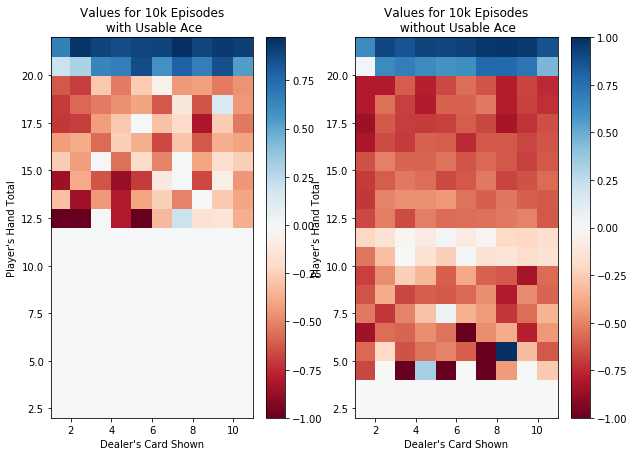

Starting 500k predictions.

500k prediction complete.

Plotting Results. 
 


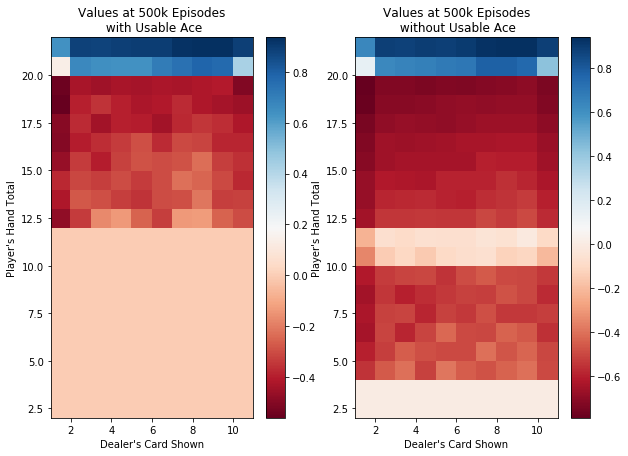

Simulation complete.


In [22]:
##########
# Part A #
##########

'''
(a) Use Monte Carlo policy evaluation to evaluate the expected returns from each state. 
Create plots for these similar to Sutton and Barto, 
Figure 5.1 where you plot the expected returns for each state. 
In this case create 2 plots:

When you have a useable ace, plot the state space with the dealer's card on the x-axis, 
and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and 
imshow to plot the value of each state under the policy described above. 
The domain of your x and y axes should include all possible states 
(2 to 21 for the player sum, and 1 to 10 for the dealer's card). Do this for for 10,000 episodes.

Repeat (1) for the states without a usable ace.
Repeat (1) for the case of 500,000 episodes.
Relwat (2) for the case of 500,000 episodes.
'''

import matplotlib.pyplot as plt

# The given policy as stated
def myPolicy(state):
    # a state includes the sum of players cards, dealers visible and a usuable ace boolean
    players_hand,_,_ = state
    
    # Hit if the players cards equal less than 20
    if players_hand < 20:
        return 1
    
    # if the player's cards are 20 or 21 stay
    else:
        return 0
    
# Prediction Fxn 

def MCPred(game, policy, num_episodes):
 
    # Dictionary to hold the stateValues as they are visited
    stateValues = {}
    
    # Dictionary to hold the returns for each state
    Returns = {}
    
    # Dictionary to hold when each state is returned
    Returns_cnt = {}
    
    # For saving average reward per episode
    average_reward_per_episode = []
    
    # counters for episodes and rewards
    total_reward = 0
    total_episodes = 0
    
    # Simulation
    for episode_num in range(1, num_episodes+1):

        # Start a new game
        curr_state = game.deal()

        # each episode is one hand til completion 
        episode = []
        
        counter = 0
        while True:

            # decide whether to hit or stay based on the player's current hand
            action = policy(curr_state)

            # update the game with the action based on the policy
            next_state,reward,game_over = game.step(action)
            
            # save the current state and the associated award with that state
            episode.append((curr_state, reward))

            # check to see if the game ended
            if game_over:
                total_reward += reward # if the game ended add that episodes reward to the total reward counter
                break

            # if not then continue playing
            curr_state = next_state
        
        # Update the counter for total episodes
        total_episodes += 1
        
        # calculate the average reward and save it
        average_reward_per_episode.append(total_reward/float(total_episodes))

        # For each state appearing in the episode:
        for i in range(len(episode)):

            # Extract info from entry
            state, reward = episode[i]

            # G = return following the first occurrence of s
            #   Sum all rewards from here to end
            G = 0
            for j in range(i,len(episode)):
                G += episode[j][1]

            # Append G to Returns[s]
            Returns[state] += G
            # Update Returns_cnt[s] so we can average reward over # of visits to state
            Returns_cnt[state] += 1

            # V[s] = average(Returns[s])
            stateValues[state] = Returns[state]/Returns_cnt[state]
        
    return stateValues, average_reward_per_episode

# Initialize a Blackjack game to play
bjack_game = Blackjack()

print("Starting simulations.\n")

print("Starting 10k predictions.\n")

Values10k, avgReward10k = MCPred(bjack_game, myPolicy, 10000)

print("10k prediction complete.\n")

print("Plotting Results.\n")

# 10k Plots

# Dealer's card shown
x = np.arange(1, 12, 1)
# Player's hand
y = np.arange(2, 23, 1)
# Create mesh grid of all possible x,y coords
X, Y = np.meshgrid(x, y)

# the statevalues when there is a usuable ace
uAce10K = np.array([Values10k[(y,x,True)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
UAce10K = uAce10K.reshape(X.shape)

# the statevalues when there is a unusuable ace
unAce10k = np.array([Values10k[(y,x,False)] for (x,y) in zip(np.ravel(X), np.ravel(Y))])
UNAce10K = unAce10k.reshape(X.shape)

plt.figure(figsize = (10,7))

# Plotting an usuable ace
plt.subplot(1,2,1)
plt.title("Values for 10k Episodes\n with Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Player's Hand Total")
plt.pcolor(X,Y,UAce10K, cmap='RdBu')
plt.colorbar()

# Plotting an unusable ace
plt.subplot(1,2,2)
plt.title("Values for 10k Episodes\n without Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Player's Hand Total")
plt.pcolor(X,Y,UNAce10K, cmap='RdBu')
plt.colorbar()

plt.show()
print("Starting 500k predictions.\n")
Values500k, avgReward500k = MCPred(bjack_game, myPolicy, 500000)
print("500k prediction complete.\n")

print("Plotting Results. \n ")

# 50K Plots

# the statevalues when there is a usuable ace
uAce500K= np.array([Values500k[(y,x,True)] for (x, y) in zip(np.ravel(X), np.ravel(Y))])
UAce500K = uAce500K.reshape(X.shape)

# The statevalues when there is an unusable ace
unAce500k = np.array([Values500k[(y,x,False)] for (x, y) in zip(np.ravel(X), np.ravel(Y))])
UNAce500k = unAce500k.reshape(X.shape)

plt.figure(figsize = (10,7))

# Plotting an usuable ace
plt.subplot(1,2,1)
plt.title("Values at 500k Episodes\n with Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Player's Hand Total")
plt.pcolor(X, Y, UAce500K, cmap = 'RdBu')
plt.colorbar()

# Plotting an unusable ace
plt.subplot(1,2,2)
plt.title("Values at 500k Episodes\n without Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Player's Hand Total")
plt.pcolor(X, Y, UNAce500k, cmap = 'RdBu')
plt.colorbar()

plt.show()

print("Simulation complete.")

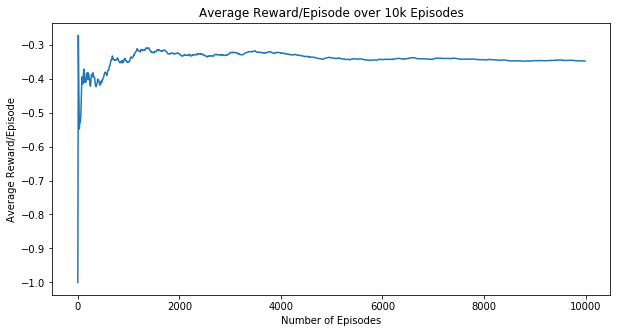

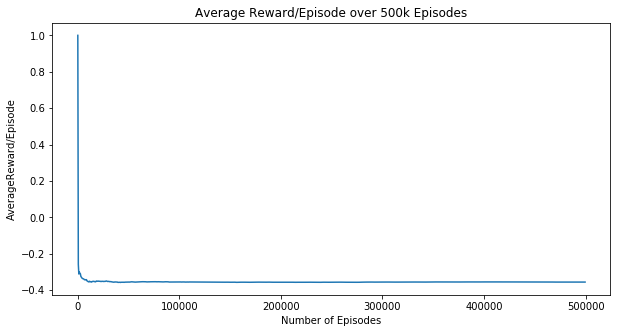

Average Reward for the 10k episodes is -0.3415
Average Reward for the 500k episodes is -0.3541


In [24]:
##########
# Part B #
##########

'''
(b) Show a plot of the overall average reward per episode vs the number of episodes. 
For both the 10,000 episode case and the 500,000 episode case, 
record the overall average reward for this policy and report that value.
'''

# Average reward for 10K Episodes
plt.figure(figsize=(10, 5))
plt.title("Average Reward/Episode over 10k Episodes")
plt.ylabel("Average Reward/Episode")
plt.xlabel("Number of Episodes")
plt.plot(range(0, len(avgReward10k),10), [avgReward10k[i] for i in range(0,len(avgReward10k), 10)])
plt.show()

# Average reward for 10K Episodes
plt.figure(figsize = (10, 5))
plt.title("Average Reward/Episode over 500k Episodes")
plt.ylabel("AverageReward/Episode")
plt.xlabel("Number of Episodes")
plt.plot(range(0,len(avgReward500k),500), [avgReward500k[i] for i in range(0,len(avgReward500k), 500)])
plt.show()

overall10k = np.sum(np.array(avgReward10k))/float(len(avgReward10k))
overall500k = np.sum(np.array(avgReward500k))/float(len(avgReward500k))
print("Average Reward for the 10k episodes is {:.4f}".format(overall10k))
print("Average Reward for the 500k episodes is {:.4f}".format(overall500k))

## 3

### [40 points] Perform Monte Carlo Control

**(a)** Using Monte Carlo Control through policy iteration, estimate the optimal policy for playing our modified blackjack game to maximize rewards. 

In doing this, use the following assumptions:
1. Initialize the value function and the state value function to all zeros
2. Keep a running tally of the number of times the agent visited each state and chose an action. $N(s_t,a_t)$ is the number of times action $a$ has been selected from state $s$. You'll need this to compute the running average. You can implement an online average as: $\bar{x}_{t} = \frac{1}{N}x_t + \frac{N-1}{N}\bar{x}_{t-1}$ 
3. Use an $\epsilon$-greedy exploration strategy with $\epsilon_t = \frac{N_0}{N_0 + N(s_t)}$, where we define $N_0 = 100$. Vary $N_0$ as needed.

Show your result by plotting the optimal value function: $V^*(s) = max_a Q^*(s,a)$ and the optimal policy $\pi^*(s)$. Create plots for these similar to Sutton and Barto, Figure 5.2 in the new draft edition, or 5.5 in the original edition. Your results SHOULD be very similar to the plots in that text. For these plots include:
1. When you have a useable ace, plot the state space with the dealer's card on the x-axis, and the player's sum on the y-axis, and use the 'RdBu' matplotlib colormap and `imshow` to plot the value of each state under the policy described above. The domain of your x and y axes should include all possible states (2 to 21 for the player sum, and 1 to 10 for the dealer's visible card).
2. Repeat (1) for the states without a usable ace.
3. A plot of the optimal policy $\pi^*(s)$ for the states with a usable ace (this plot could be an imshow plot with binary values).
4. A plot of the optimal policy $\pi^*(s)$ for the states without a usable ace (this plot could be an imshow plot with binary values).

**(b)** Show a plot of the overall average reward per episode vs the number of episodes. What is the average reward your control strategy was able to achieve?

*Note: convergence of this algorithm is extremely slow. You may need to let this run a few million episodes before the policy starts to converge. You're not expected to get EXACTLY the optimal policy, but it should be visibly close.* 

**ANSWER**

In [20]:
##########
# Part A #
##########

'''
nitialize the value function and the state value function to all zeros
Keep a running tally of the number of times the agent visited each state and chose an action.  
N(st,at)  is the number of times action  a  has been selected from state  s. 
You'll need this to compute the running average. 
You can implement an online average as:  x¯t=1Nxt+N−1Nx¯t−1 
Use an  ϵ -greedy exploration strategy with  ϵt=N0N0+N(st) , 
where we define  N0=100 . Vary  N0  as needed.
'''

import matplotlib.pyplot as plt
import random


# Define the policy function we will use
def myPolicy(policy, state, epsilon):
      
    # determine the best policy in the state.
    bestAction = policy[state]
    otherAction = 0 if bestAction == 1 else 1
    
    # Generate a random number in [0,1]
    num = random.uniform(0, 1)
    # check for (1-epsilon) case where we choose to EXPLORE
    if num >= epsilon:
        return otherAction
    # Most of the time choose to EXPLOIT
    else:
        return bestAction
    
def MCControl(game, policy, num_iters):

    # A Dictionary to hold action value pairs
    actionPair = {}
    
    # A Dictionary to hold the returns for each action value pairs
    Returns = {}
    
    # A Dictionary to store the number of times the state,action was taken
    Returns_cnt = {}
    
    # A Dictionary to hold the policy for each possible state
    Policy = {}
    
    # Array for saving average reward per episode
    average_reward_per_episode = []
    
    # array for the running average reward
    running_overall_average_reward = []
    
    # counters for the total reward and episodes
    total_reward = 0
    episode_counter = 0
    
    for it in range(1, num_iters+1):

        # Start the game and set the current state
        curr_state = game.deal()

        # Array to hold all of the episodes
        episode = []
        
        # Counters to hold the total rewards 
        total_episode_reward = 0
        counter = 0
        
        while True:

            # Determine action based on the current policy function
            N_0 = 100.
            N_st = Returns_cnt[(curr_state,1)] + Returns_cnt[(curr_state,0)]
            eps = 1- N_0/(N_0 + N_st)
            action = policy(Policy, curr_state, eps)

            # Take the next step based on the best action for that state
            next_state, reward, game_over = game.step(action)

            # Update counters for average reward/episode
            total_episode_reward += reward
            counter += 1
            
            # Save the state, reward, and action for the episode
            episode.append((curr_state, reward, action))

            # if the game is over update the total reward
            if game_over:
                total_reward += reward
                break

            # else go to the next state
            curr_state = next_state

        # Save average reward for this episode
        average_reward_per_episode.append(total_episode_reward/float(counter))
        episode_counter += 1
        running_overall_average_reward.append(total_reward/float(episode_counter))       
    
        # For each state,action pair appearing in the episode:
        for i in range(len(episode)):

            state,reward,action = episode[i]

            # G is the return following the first time to that state 
            G = 0
            for j in range(i,len(episode)):
                G += episode[j][1]

            # Append episodic return G to Returns
            Returns[(state,action)] += G
            
            # update Returns_cnt in order to average reward over all visits to that state
            Returns_cnt[(state,action)] += 1

            # Update the action pair based on the average returns from that state
            actionPair[(state,action)] = Returns[(state,action)]/Returns_cnt[(state,action)]
        
        # For each state in the episode
        for i in range(len(episode)):
            state,_,_ = episode[i]
            # Find the best action for that state. 
            a_hit = actionPair[(state,1)]
            a_stay = actionPair[(state,0)]
            a_best = 1 if a_hit > a_stay else 0
            Policy[state] = a_best
            
    return actionPair, Policy, average_reward_per_episode, running_overall_average_reward

# Initialize a Blackjack game to play
bjack_game = Blackjack()

print("Starting simulations.\n")

# Conduct 5 Million episodes/iterations of the greedy policy for results.
actionPair, policy, avgReward, runningAvg = MCControl(bjack_game, myPolicy, 5000000)

print("Simulations complete.")

Starting simulations.

Simulations complete.


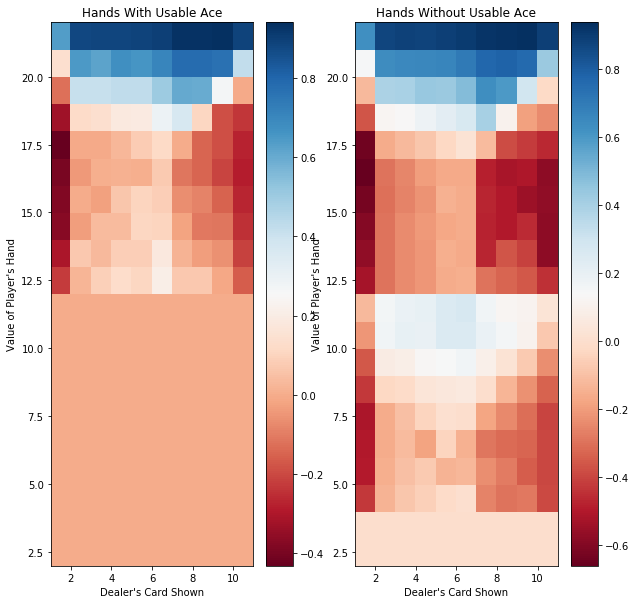

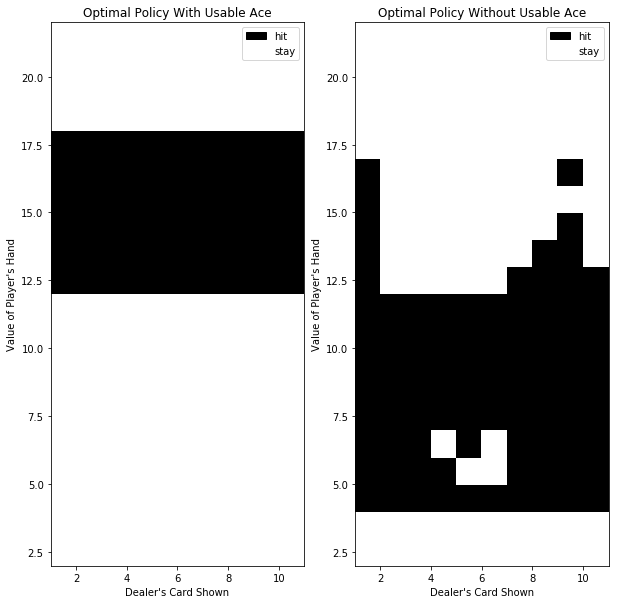

In [17]:
import matplotlib.patches as mpatches

# Dealers card showing
x = np.arange(1, 12, 1)
# Player's hand total 
y = np.arange(2, 23, 1)
# Create mesh grid of all possible x,y coords
X, Y = np.meshgrid(x, y)

# Grab the value in V for each x,y coordinate for 'usable_Ace = True'
q_usable = np.maximum(np.array([actionPair[((y, x, True), 0)] for (x, y) in zip(np.ravel(X), np.ravel(Y))]), 
                      np.array([actionPair[((y, x, True), 1)] for (x, y) in zip(np.ravel(X), np.ravel(Y))])) 
Q_usable = q_usable.reshape(X.shape)

# Grab the value in V for each x,y coordinate for 'usable_Ace = False'
q_unusable = np.maximum(np.array([actionPair[((y, x, False), 0)] for (x, y) in zip(np.ravel(X), np.ravel(Y))]), 
                        np.array([actionPair[((y, x, False), 1)] for (x, y) in zip(np.ravel(X), np.ravel(Y))])) 
Q_unusable = q_unusable.reshape(X.shape)

# Policy fxn for states with unusable ace
pol_unusable = np.array([myPolicy(policy, (y, x, False), 1.1) for (x, y) in zip(np.ravel(X), np.ravel(Y))])
Policy_unusable = pol_unusable.reshape(X.shape)

# Policy fxn for states with usable ace
pol_usable = np.array([myPolicy(policy, (y, x, True), 1.1) for (x, y) in zip(np.ravel(X), np.ravel(Y))])
Policy_usable = pol_usable.reshape(X.shape)


plt.figure(figsize=(10,10))

# plot the player's hand with usuable aces
plt.subplot(1,2,1)
plt.title("Hands With Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.pcolor(X, Y, Q_usable, cmap = 'RdBu')
plt.colorbar()

# plot the players hand with unusuable aces
plt.subplot(1,2,2)
plt.title("Hands Without Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.pcolor(X, Y, Q_unusable, cmap = 'RdBu')
plt.colorbar()
plt.show

plt.figure(figsize=(10,10))
# plot the optimal policy with usuable aces
plt.subplot(1,2,1)
plt.title("Optimal Policy With Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.pcolor(X, Y, Policy_usable, cmap = 'Greys')

legend_hit = mpatches.Patch(color = 'black', label = 'hit')
legend_stay = mpatches.Patch(color = 'white', label = 'stay')
plt.legend(handles = [legend_hit,legend_stay])

# plot the optimal policy with unusuable aces
plt.subplot(1,2,2)
plt.title("Optimal Policy Without Usable Ace")
plt.xlabel("Dealer's Card Shown")
plt.ylabel("Value of Player's Hand")
plt.pcolor(X, Y, Policy_unusable, cmap = 'Greys')

legend_hit = mpatches.Patch(color = 'black', label = 'hit')
legend_stay = mpatches.Patch(color = 'white', label = 'stay')

plt.legend(handles = [legend_hit,legend_stay])

plt.show()

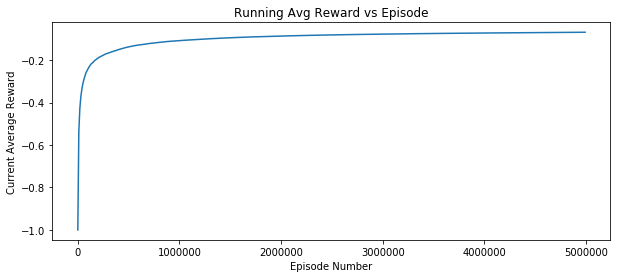

Overall Average Reward: -0.0587 


In [21]:
##########
# Part B #
##########

'''
Show a plot of the overall average reward per episode vs the number of episodes. 
What is the average reward your control strategy was able to achieve?
'''

plt.figure(figsize=(10,4))
plt.title("Running Avg Reward vs Episode")
plt.ylabel("Current Average Reward")
plt.xlabel("Episode Number")
plt.plot(range(0,len(runningAvg),10000), [runningAvg[i] for i in range(0,len(runningAvg),10000)])
#plt.plot(running_avg)
plt.show()

# Calculate overall average rewards for 10k and 500k runs
# for 10k
overallAvgReward = np.sum(np.array(avgReward))/float(len(avgReward))
print("Overall Average Reward: {:.4f} ".format(overallAvgReward))

## 4

### [10 points] Discuss your findings

Compare the performance of your human control policy, the naive policy from question 2, and the optimal control policy in question 3. 
**(a)** Which performs best? Why is this the case? 
**(b)** Could you have created a better policy if you knew the full Markov Decision Process for this environment? Why or why not?

**ANSWER**

**(A)** 
We can see that the human level policy at 50 games is -0.4. 
The Monte Carlo Policy Evaluations at 10,000 games is -0.3415 and at 500,000 games is -0.3541. 
The Monte Carlo Control is at 5 million games is -0.0587.

This tells us that ultimately the MC Control is the best performance when taking average reward in account. The MC PE doesn't
take repeat visits in account therefore its not learning. While my MC Control isn't optimal, because it still failed to converge
after 5 million games, it is still substantially better than the other two methods, despite the longer time to work.

**(B)**
If given enough iterations (in this case more than 5 millions), MC control should converge to an optimal policy. However, with 
full knowledge of a Markov Decision Process we could ultimately converge at the optimal policy faster than simulating games
because we would have full knowledge of the states and probability. So while the policy itself would be the same, the speed it took
to get there would potentially be faster. Given that there could be infinite states in a different problem, the MC Control will
always be the best method for approximating the system, even if it doesn't have the resources to get the absolute best policy
possible. 
